## Generating different Time-Series:

In [1]:
import tensorflow as tf 

print('tensorflow version: ', tf.__version__)

tensorflow version:  2.0.0-dev20191002


In [33]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from tensorflow import keras 
import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline 

In [3]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
    """
    plots the time-series with start and  end values
    """
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    
    if label:
        plt.legend(fontsize=14)
        
    plt.grid(True)

## Trend and Sessionality:

In [4]:
def trend(time, slope=0):
    return slope * time 

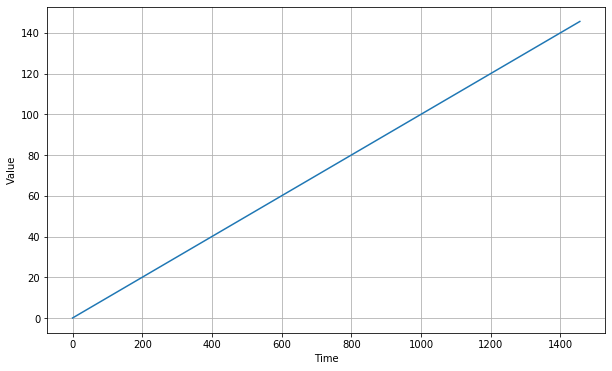

In [6]:
# creating time-series that just trends upwards

time = np.arange(4 * 364 + 1)
baseline = 10
series = trend(time, slope=0.1)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

## Time-Series with Sessional Pattern:

In [10]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

In [11]:
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

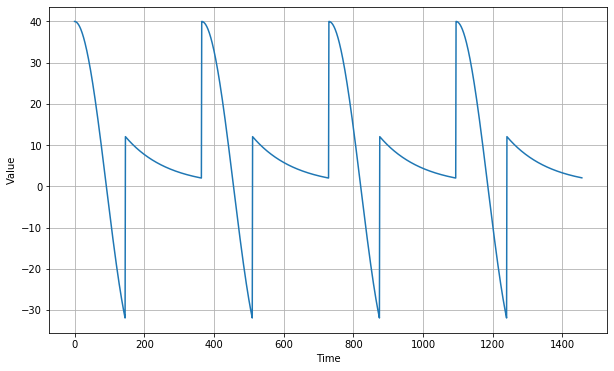

In [12]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Time-Series with both Trend & Seasionality:

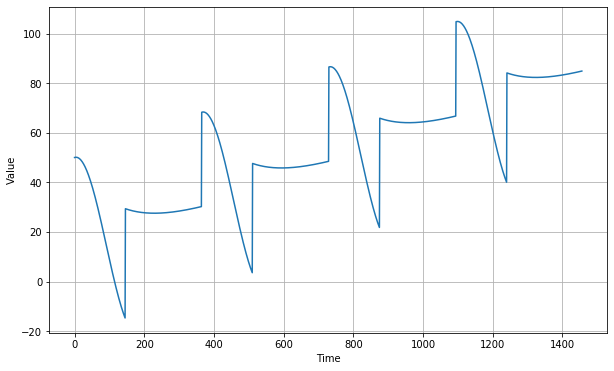

In [13]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Noise:

In practice few real-life time series have such a smooth signal. They usually have some noise, and the signal-to-noise ratio can sometimes be very low. Let's generate some white noise:

In [14]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

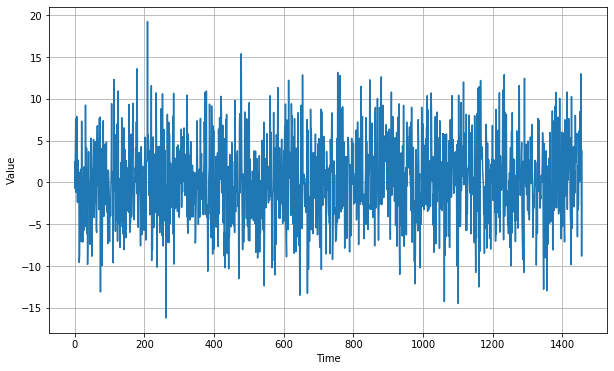

In [15]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

Now let's add some white noise to the time series:

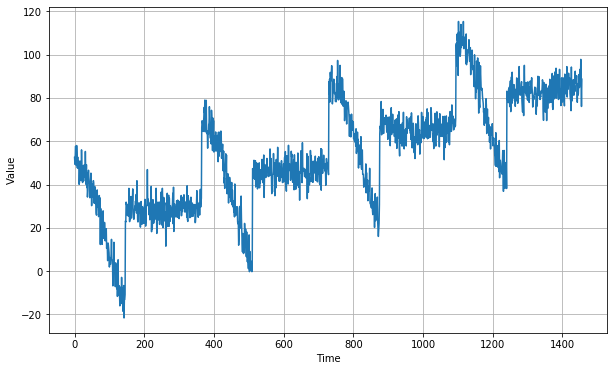

In [16]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

All right, this looks realistic enough for now. Let's try to forecast it. We will split it into two periods: the training period and the validation period (in many cases, you would also want to have a test period). The split will be at time step 1000

In [17]:
split_time = 1000
time_train = time[:split_time] # training time 
x_train = series[:split_time] # x_train data for training time 
time_valid = time[split_time:] # validatioin time 
x_valid = series[split_time:] # x_validation data for validation time 

In [18]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [19]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

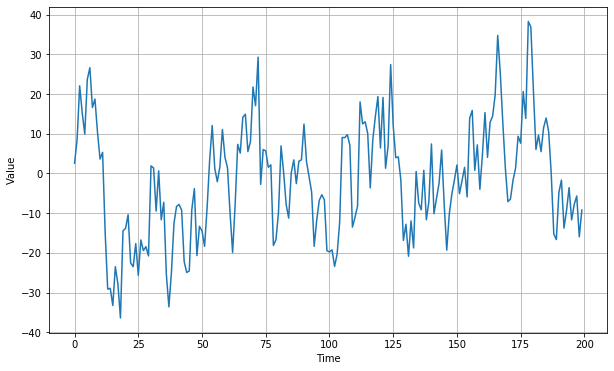

In [20]:
plt.figure(figsize=(10,6))
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

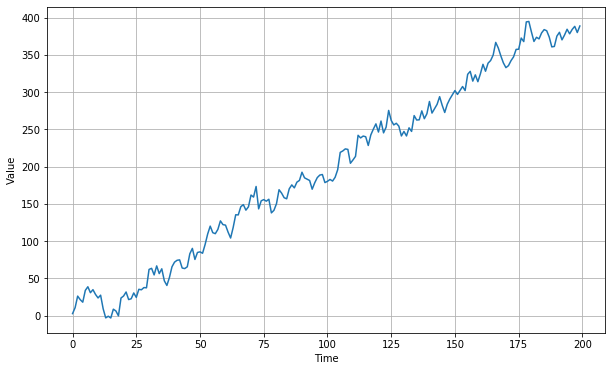

In [21]:
plt.figure(figsize=(10,6))
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

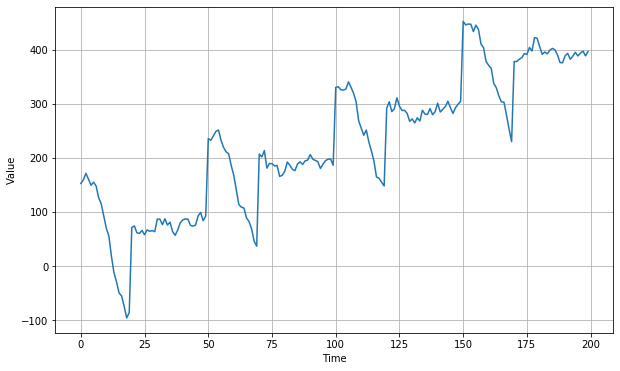

In [22]:
plt.figure(figsize=(10,6))
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

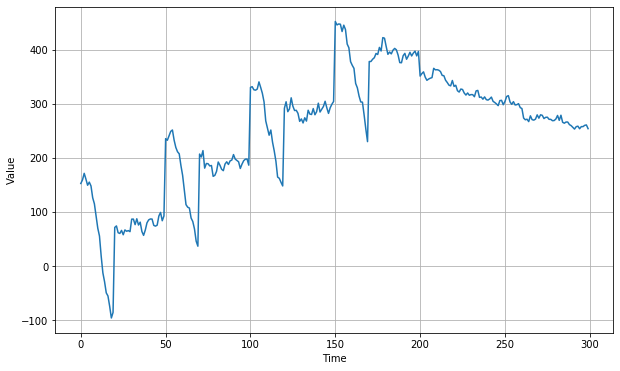

In [23]:
plt.figure(figsize=(10,6))
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [24]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series

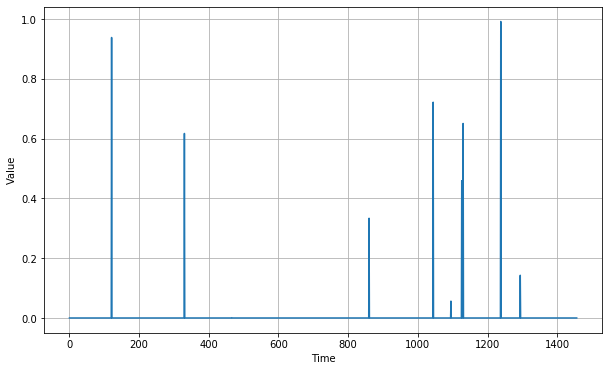

In [25]:
plt.figure(figsize=(10,6))
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [26]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
                ar[step] += φ * ar[step - lag]
    return ar

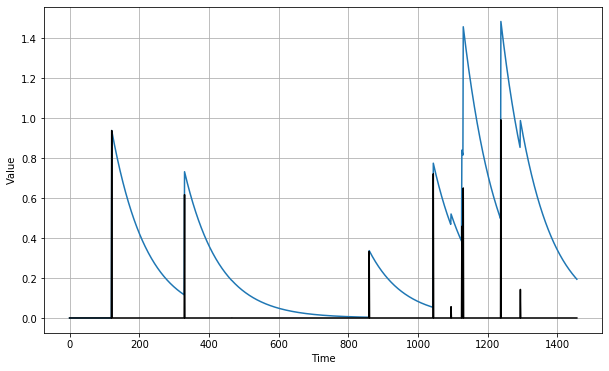

In [27]:
plt.figure(figsize=(10,6))
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

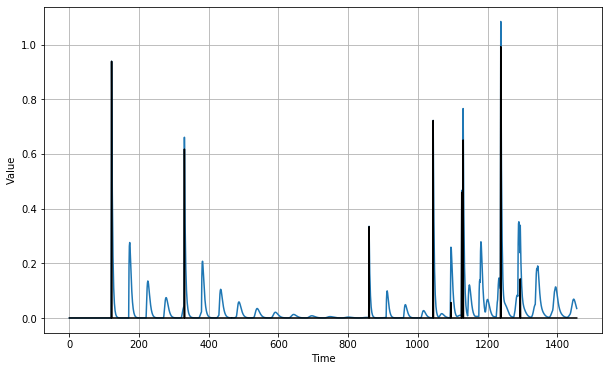

In [35]:
plt.figure(figsize=(10,6))
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

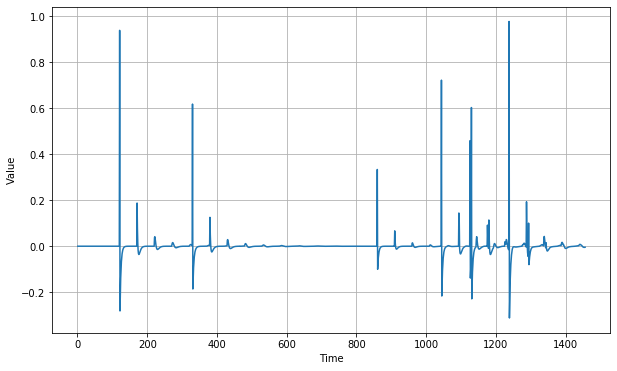

In [36]:
plt.figure(figsize=(10,6))
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

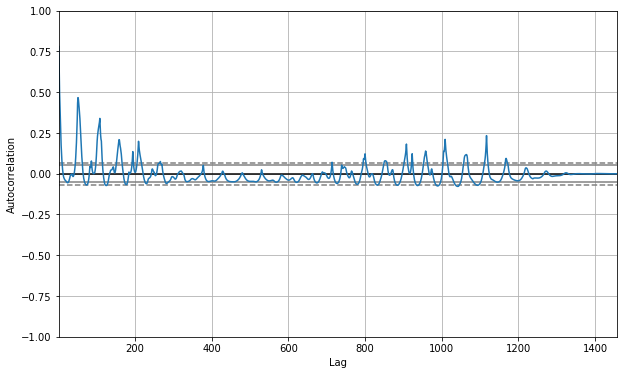

In [37]:
plt.figure(figsize=(10,6))
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [31]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1456
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2202.895
Method:                       css-mle   S.D. of innovations              0.053
Date:                Tue, 21 Jan 2020   AIC                          -4391.789
Time:                        12:05:02   BIC                          -4354.805
Sample:                             1   HQIC                         -4377.991
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.655e-05      0.001      0.029      0.977      -0.002       0.002
ar.L1.D.y     -0.1579      0.026     -6.042      0.000      -0.209      -0.107
ar.L2.D.y     -0.1459      0.026     -5.516      0.0